## Финальное соревнование

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

В данном задании вас ждет неизвестная зависимость. Ваша основная задача: **построить две лучших модели**, минимизирующих среднеквадратичную ошибку (MSE):
1. На первую модель не налагается ограничений.
2. Вторая модель должна быть **линейной**, т.е. представлять собой линейную комбинацию признаков плюс свободный член: $\boldsymbol{w}^{\top}\boldsymbol{x} + b$. При этом __вы можете использовать базовые математические операции для преобразования признаков__: np.exp, np.log, np.pow (полный список доступен в [документации](https://numpy.org/doc/stable/reference/routines.math.html)), а также линейные операции над ними (сумма, умножение на число и пр.). Для преобразования признаков вам будет необходимо написать функцию `my_transformation`. __Кол-во параметров (весов) используемых второй моделью не должно превышать 15 (включая свободный член).__

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в будущем писать код более уверенно

In [1]:
import os
import json
import shap

import sklearn
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingRegressor

Загрузка данных происходит ниже. Если она не срабатывает, самостоятельно скачайте файл `hw_final_open_data.npy` и положите его в ту же директорию, что и ноутбук.

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_data.npy -O hw_final_open_data.npy
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_target.npy -O hw_final_open_data.npy

In [282]:
assert os.path.exists('hw_final_open_data.npy'), 'Please, download `hw_final_open_data.npy` and place it in the working directory'
assert os.path.exists('hw_final_open_target.npy'), 'Please, download `hw_final_open_target.npy` and place it in the working directory'
data = np.load('hw_final_open_data.npy', allow_pickle=False)
#data = np.delete(data, [6, 4, 3, 2], 1)
#data = 2 * (data - data.mean(0)) / (data.max(0) - data.min(0))
print(data.max(0))
print(data.min(0))
"""
print(data[:, 2])
data[:, 6] = data[:, 6] * data[:, 2]
data[:, 2] = data[:, 0] * np.exp(data[:, 2])
#data = np.delete(data, [2], 1)
data = (data - data.mean(0))/ (data.max() - data.min())
print(data[:, 2])
"""
target = np.load('hw_final_open_target.npy', allow_pickle=False)

[-0.5599184469039173  1.250292832700845  -0.5686304806687642
  0.4481731189870108 -0.4768987216716103  3.853661601482751
 -0.5754375665682154]
[-0.5674541615338221  -0.5072694823213797  -0.5686304806883347
 -0.44891024892504583 -0.5367850378473128  -0.3678688099046231
 -0.575437566822411  ]


Разбивка на `train` и `val` опциональна и сделана для вашего удобства.

In [283]:
train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.3)

In [275]:
def my_transformation(feature_matrix: np.ndarray):
    new_feature_matrix = np.zeros((feature_matrix.shape[0], feature_matrix.shape[1]))
    new_feature_matrix[:, :feature_matrix.shape[1]] = feature_matrix

    new_feature_matrix[:, 0] = feature_matrix[:, 0] * feature_matrix[:, 1]
    
    new_feature_matrix[:, 2] = (feature_matrix[:, 4]) * (feature_matrix[:, 2]) + feature_matrix[:, 1]/ (feature_matrix[:, 6])
    
    new_feature_matrix[:, 4] = feature_matrix[:, 1] + feature_matrix[:, 3]
    
    new_feature_matrix[:, 1] = np.array([1 if i == feature_matrix[:, 2].max() else -1 for i in feature_matrix[:, 2]])
    new_feature_matrix[:, 6] = np.array([1 if i == feature_matrix[:, 6].max() else -1 for i in feature_matrix[:, 6]])
    #new_feature_matrix = np.delete(new_feature_matrix, [6, 1], 1)
    return new_feature_matrix

In [284]:
estimators = [
    ('lr1', LinearRegression()),
    ('rf', RandomForestRegressor()),
    ('r', Ridge())
]
clf = StackingRegressor(
    estimators=estimators, final_estimator=Ridge()
)

### Модель №1
Напоминаем, в первой части задания ваша основная задача – получить наилучший результат без ограничений на модель. Сдаваться будут только предсказания модели.

Пример с использованием Random Forest доступен ниже.

In [285]:
#rf = RandomForestRegressor(n_estimators=100, min_samples_split=2, max_features=100, criterion='friedman_mse')
#rf = GradientBoostingRegressor(learning_rate=0.05, n_estimators=120)
train_x = my_transformation(train_x)
valid_x = my_transformation(valid_x)
clf.fit(my_transformation(data), target)
print(
    f'train mse =\t {mean_squared_error(np.round(clf.predict(train_x), 2), np.round(train_y)):.5f}',
    f'validation mse = {mean_squared_error(np.round(clf.predict(valid_x)), np.round(valid_y)):.5f}',
    sep='\n'
)


train mse =	 0.16082
validation mse = 0.22500


In [206]:
clf.feature_importances_

AttributeError: 'StackingRegressor' object has no attribute 'feature_importances_'

In [256]:
print(
    f'train mse =\t {mean_squared_error(np.round(clf.predict(train_x), 2), np.round(train_y)):.5f}',
    f'validation mse = {mean_squared_error(np.round(clf.predict(valid_x)), np.round(valid_y)):.5f}',
    sep='\n'
)

train mse =	 0.17836
validation mse = 0.20833


##### Сдача первой части соревнования
Загрузите файл `hw_final_closed_data.npy` (ссылка есть на странице с заданием). Если вы используете sklearn-совместимую модель, для генерации посылки вы можете воспользоваться функцией `get_predictions`. В ином случае перепишите функцию для вашей модели и запустите код под следующей ячейкой для генерации посылки.

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_closed_data.npy -O hw_final_closed_data.npy

In [286]:
assert os.path.exists('hw_final_closed_data.npy'), 'Please, download `hw_final_closed_data.npy` and place it in the working directory'
closed_data = np.load('hw_final_closed_data.npy', allow_pickle=False)

Если необходимо, преобразуйте данные. Преобразованную матрицу объект-признак сохраните в переменную `closed_data`.

In [ ]:
# optional transformations

In [279]:
def get_predictions(model, eval_data, step=10):
    predicted_values = model.predict(eval_data)
    return predicted_values

Обращаем ваше внимание, предсказания округляются до сотых!

In [287]:
predicted_values = np.round(get_predictions(model=clf, eval_data=my_transformation(closed_data)), 2)

assert predicted_values.shape == (closed_data.shape[0], ) # predictions should be just one-dimensional array

print(
    f'train mse =\t {mean_squared_error(np.round(clf.predict(train_x), 2), np.round(train_y)):.5f}',
    f'validation mse = {mean_squared_error(np.round(clf.predict(valid_x)), np.round(valid_y)):.5f}',
    sep='\n'
)


train mse =	 0.16082
validation mse = 0.22500


In [288]:
# do not change the code in the block below
# __________start of block__________
def float_list_to_comma_separated_str(_list):
    _list = list(np.round(np.array(_list), 2))
    return ','.join([str(x) for x in _list])

submission_dict = {
    'predictions': float_list_to_comma_separated_str(predicted_values)
}
with open('submission_dict_final_p01.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
    
print('File saved to `submission_dict_final_p01.npy`')
# __________end of block__________

File saved to `submission_dict_final_p01.npy`


### Модель №2
Функция `my_transformation` принимает на вход матрицу объект-признак (`numpy.ndarray` типа `np.float`) и преобразует ее в новую матрицу. Данная функция может использовать только numpy-операции, а также арифметические действия.

Для примера доступна функция ниже. Она лишь добавляет новый признак, представляющий собой произведение первого и второго исходных признаков (считая с нуля).

In [195]:
def my_transformation(feature_matrix: np.ndarray):
    new_feature_matrix = np.zeros((feature_matrix.shape[0], feature_matrix.shape[1]))
    new_feature_matrix[:, :feature_matrix.shape[1]] = feature_matrix

    new_feature_matrix[:, 0] = feature_matrix[:, 0] * feature_matrix[:, 1]
    
    new_feature_matrix[:, 2] = (feature_matrix[:, 4]) * (feature_matrix[:, 2]) + feature_matrix[:, 1]/ (feature_matrix[:, 6])
    
    new_feature_matrix[:, 4] = feature_matrix[:, 1] + feature_matrix[:, 3]
    
    new_feature_matrix[:, 1] = np.array([1 if i == feature_matrix[:, 2].max() else -1 for i in feature_matrix[:, 2]])
    new_feature_matrix[:, 6] = np.array([1 if i == feature_matrix[:, 6].max() else -1 for i in feature_matrix[:, 6]])
    #new_feature_matrix = np.delete(new_feature_matrix, [6, 1], 1)
    return new_feature_matrix

In [196]:
transformed_train_x = my_transformation(train_x)
transformed_valid_x = my_transformation(valid_x)
transformed_valid_x.mean(0)

array([-0.14927777086054855  ,  0.875                ,
       -0.17970913587279558  ,  0.0031529121427177026,
        0.27027990262704477  ,  1.5400229541074577   ,
        0.8333333333333334   ])

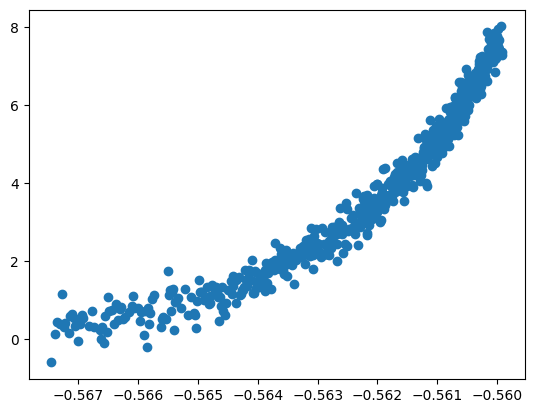

In [187]:
fig = plt.scatter(train_x[:, 0], train_y)

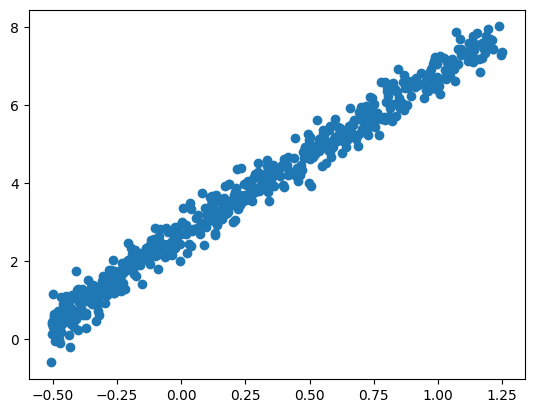

In [157]:
fig = plt.scatter(train_x[:, 1], train_y)

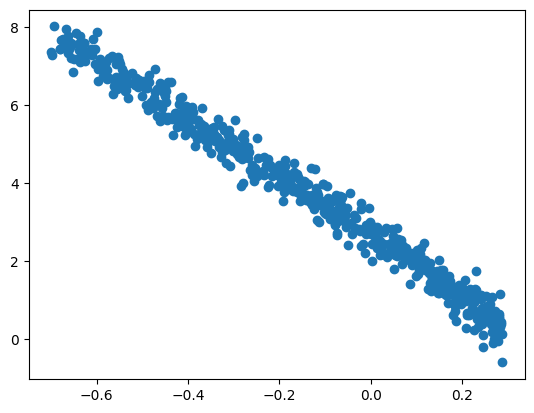

In [158]:
fig = plt.scatter(train_x[:, 1] * train_x[:, 0], train_y)

In [ ]:
fig = plt.scatter(train_x[:, 2], train_y)

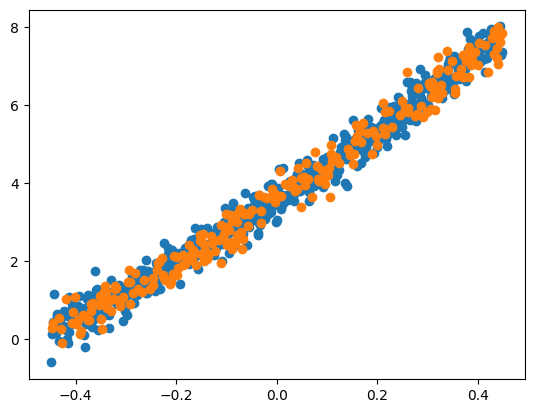

In [159]:
fig = plt.scatter(train_x[:, 3], train_y)
fig = plt.scatter(valid_x[:, 3], valid_y)

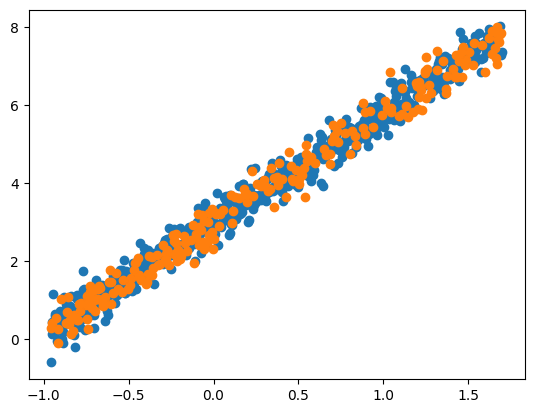

In [160]:
fig = plt.scatter(train_x[:, 3] + train_x[:, 1], train_y)
fig = plt.scatter(valid_x[:, 3] + valid_x[:, 1], valid_y)

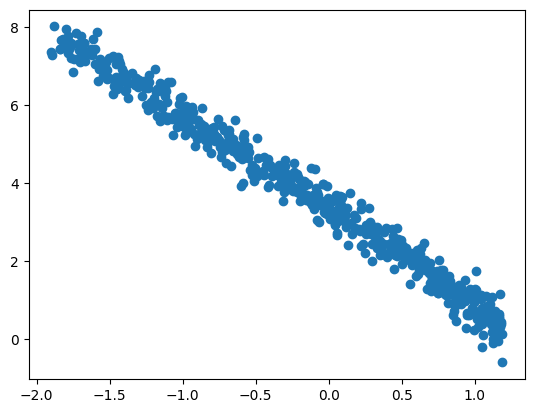

In [161]:
fig = plt.scatter((train_x[:, 4]) * (train_x[:, 2]) + train_x[:, 1]/ (train_x[:, 6]), train_y)
#fig = plt.scatter((valid_x[:, 4]), valid_y)

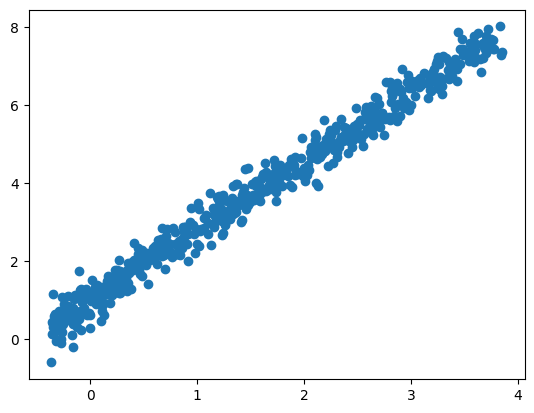

In [162]:
fig = plt.scatter(train_x[:, 5], train_y)

[-0.5686304806687642 -0.5686304806687642 -0.5686304806687642
 -0.5686304806687642 -0.5686304806687642 -0.5686304806687642
 -0.5686304806687642 -0.5686304806687642 -0.5686304806687642
 -0.5686304806687642 -0.5686304806687642 -0.5686304806687642
 -0.5686304806687642 -0.5686304806687652 -0.5686304806687642
 -0.5686304806687642 -0.5686304806687642 -0.5686304806687642
 -0.5686304806687642 -0.5686304806687642 -0.5686304806687642
 -0.5686304806687642 -0.5686304806687642 -0.5686304806687642
 -0.5686304806687743 -0.5686304806687642 -0.5686304806687642
 -0.5686304806687642 -0.5686304806687642 -0.5686304806687642
 -0.5686304806687642 -0.5686304806687642 -0.5686304806687642
 -0.5686304806687642 -0.5686304806767137 -0.5686304806687642
 -0.5686304806687642 -0.5686304806687642 -0.5686304806687642
 -0.5686304806687642 -0.5686304806687642 -0.5686304806687642
 -0.5686304806687642 -0.568630480668807  -0.5686304806687642
 -0.5686304806687642 -0.5686304806687642 -0.5686304806687642
 -0.5686304806687642 -0.

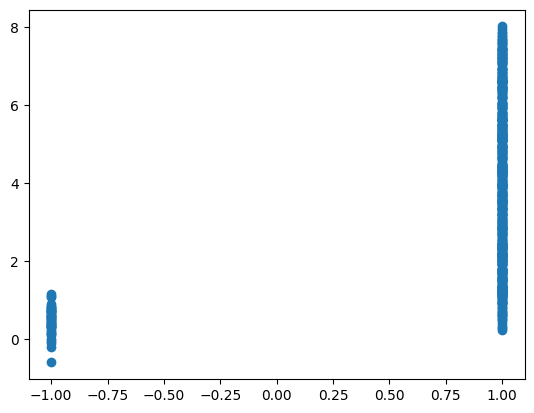

In [147]:
np.set_printoptions(precision=30)
print(train_x[:, 2])
temp1 = np.array([1 if i == train_x[:, 2].max() else -1 for i in train_x[:, 2]])
temp2 = np.array([1 if i == train_x[:, 6].max() else -1 for i in train_x[:, 6]])
plt.scatter(temp1, train_y)

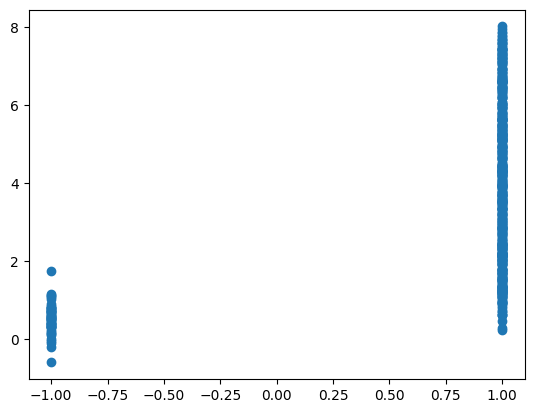

In [151]:
fig = plt.scatter(temp2, train_y)

In [197]:
lr = Ridge()
lr.fit(my_transformation(data), target)

print(
    f'train mse =\t {mean_squared_error(lr.predict(transformed_train_x), train_y):.5f}',
    f'validation mse = {mean_squared_error(lr.predict(transformed_valid_x), valid_y):.5f}',
    sep='\n'
)

train mse =	 0.08873
validation mse = 0.09297


Обращаем ваше внимание, что параметры линейной модели будут округляться до __четырех знаков после запятой__. Это не должно сильно повлиять на качество предсказаний:

In [198]:
original_predictions = lr.predict(transformed_train_x)
rounded_predictions = transformed_train_x.dot(np.round(lr.coef_, 4)) + np.round(lr.intercept_, 4)


assert np.allclose(original_predictions, rounded_predictions, atol=1e-3)

Параметры вашей модели:

In [199]:
w_list = list(np.round(lr.coef_, 4))
print(f'w = {list(np.round(lr.coef_, 4))}\nb = {np.round(lr.intercept_, 4)}')

w = [-0.1643, 0.0138, -0.5113, 0.3567, 0.6377, 0.8681, 0.0318]
b = 2.0802


Напоминаем, ваша модель не должна использовать более 15 параметров (14 весов плюс свободный член).

In [ ]:
assert len(w_list) + 1 <= 15

##### Сдача второй части соревнования
Для сдачи вам достаточно отправить функцию `my_transformation` и параметры вашей модели в контест в задачу №2. Пример посылки доступен ниже

In [ ]:
# __________example_submission_start__________

def my_transformation(feature_matrix: np.ndarray):
    new_feature_matrix = np.zeros((feature_matrix.shape[0], feature_matrix.shape[1]+1))
    new_feature_matrix[:, :feature_matrix.shape[1]] = feature_matrix
    new_feature_matrix[:, -1] = feature_matrix[:, 0
    ] * feature_matrix[:, 1]
    return new_feature_matrix

w_submission = [-0.0027, -0.2637, 0.0, -0.1134, -0.0165, -0.9329, 0.0, 0.1293]
b_submission = 1.1312
# __________example_submission_end__________

In [201]:
closed_data = np.load('hw_final_closed_data.npy', allow_pickle=False)
#closed_data = my_transformation(closed_data)

In [124]:
predicted_values = np.round(get_predictions(model=lr, eval_data=closed_data), 2)

assert predicted_values.shape == (closed_data.shape[0], ) # predictions should be just one-dimensional array


In [125]:
# do not change the code in the block below
# __________start of block__________
def float_list_to_comma_separated_str(_list):
    _list = list(np.round(np.array(_list), 2))
    return ','.join([str(x) for x in _list])

submission_dict = {
    'predictions': float_list_to_comma_separated_str(predicted_values)
}
with open('submission_dict_final_p01.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
    
print('File saved to `submission_dict_final_p01.npy`')
# __________end of block__________

File saved to `submission_dict_final_p01.npy`


На этом задание завершено. Поздравляем!

In [202]:
def get_predictions(model, eval_data, step=10):
    predicted_values = model.predict(eval_data)
    return predicted_values

In [203]:
predicted_values = np.round(get_predictions(model=lr, eval_data=my_transformation(closed_data)), 2)

assert predicted_values.shape == (closed_data.shape[0], ) # predictions should be just one-dimensional array

print(
    f'train mse =\t {mean_squared_error(np.round(lr.predict(my_transformation(train_x)), 2), np.round(train_y)):.5f}',
    f'validation mse = {mean_squared_error(np.round(lr.predict(my_transformation(valid_x))), np.round(valid_y)):.5f}',
    sep='\n'
)


train mse =	 0.18520
validation mse = 0.25417


In [193]:
# do not change the code in the block below
# __________start of block__________
def float_list_to_comma_separated_str(_list):
    _list = list(np.round(np.array(_list), 2))
    return ','.join([str(x) for x in _list])

submission_dict = {
    'predictions': float_list_to_comma_separated_str(predicted_values)
}
with open('submission_dict_final_p01.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
    
print('File saved to `submission_dict_final_p01.npy`')
# __________end of block__________

File saved to `submission_dict_final_p01.npy`
